In [916]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [917]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline

In [918]:
class prediction_model:

	def __init__(self, end_classifier, open_classifier, direction_classifer, filepath, years=4):

		self.end_prediction = end_classifier
		self.open_prediction = open_classifier
		self.direction_prediction = direction_classifer
		self.path = filepath

		data = self.translate_data(filepath)


		## drop every date before 4 years ago today
		data = data[data['Date'] > pd.to_datetime('today') - pd.DateOffset(years=years)]


		direction_data = data.copy()
		direction_data['c2cChange'] = direction_data['Close/Last'].shift(-1) - direction_data['Close/Last']
		# direction_data['o2cChange'] = direction_data['Close/Last'] - direction_data['Open']
		# direction_data['o2oChange'] = direction_data['Open'].shift(-1) - direction_data['Open']
		direction_data['c2cDirection'] = direction_data['c2cChange'].apply(lambda x: 1 if x > 0 else -1)
		# direction_data['o2cDirection'] = direction_data['o2cChange'].apply(lambda x: 1 if x > 0 else -1)
		# direction_data['o2oDirection'] = direction_data['o2oChange'].apply(lambda x: 1 if x > 0 else -1)

		
		self.end_prediction_data, self.end_names = self.build_training(data, 'Close/Last')
		self.open_prediction_data, self.open_names = self.build_training(data, 'Open')

		# self.direction_prediction_data, self.direction_names = self.build_training(direction_data, 'c2cDirection', True)
		self.direction_prediction_data, self.change_names = self.build_training(direction_data, 'c2cChange', 2)

		### reset indexes
		self.end_prediction_data = self.end_prediction_data.reset_index(drop=True)
		self.open_prediction_data = self.open_prediction_data.reset_index(drop=True)
		self.direction_prediction_data = self.direction_prediction_data.reset_index(drop=True)

		self.direction_prediction_data['const'] = 1



		# print(self.end_prediction_data)
		# print(self.open_prediction_data)
		print(self.direction_prediction_data)

		end_X = self.end_prediction_data.drop(columns=['High', 'Low', 'Volume', 'Close/Last', 'Date'] , axis=1)
		end_y = self.end_prediction_data['Close/Last']


		print("x data:")

		print(end_X)
		

		open_X = self.open_prediction_data.drop(columns=['High', 'Low', 'Volume', 'Open', 'Date'] , axis=1)

		print(open_X)
		open_y = self.open_prediction_data['Open'].shift(-1)

		open_y = open_y.dropna()
		open_X = open_X.drop(open_X.index[-1])

		c2c_dir_X = self.direction_prediction_data.drop(columns=['High', 'Low', 'Volume', 'c2cDirection', 'Date','Open', 'Close/Last'], axis=1)
		print(c2c_dir_X)

		c2c_dir_y = self.direction_prediction_data['c2cDirection'].shift(-1)

		c2c_dir_y = c2c_dir_y.dropna()
		c2c_dir_X = c2c_dir_X.drop(c2c_dir_X.index[-1])

		print("end shapes: ", end_X.shape, end_y.shape)
		print("open shapes: ", open_X.shape, open_y.shape)
		print("direction shapes: ", c2c_dir_X.shape, c2c_dir_y.shape)

		self.end_X_train, self.end_X_test, self.end_y_train, self.end_y_test = train_test_split(end_X, end_y, test_size=0.35, shuffle=False, random_state=0)
		self.open_X_train, self.open_X_test, self.open_y_train, self.open_y_test = train_test_split(open_X, open_y, test_size=0.35, shuffle=False, random_state=0)
		self.direction_X_train, self.direction_X_test, self.direction_y_train, self.direction_y_test = train_test_split(c2c_dir_X, c2c_dir_y, test_size=0.8, shuffle=False, random_state=0)

######
####
##		Helper Functions to handle initiation of the model
#
###
##	Heloper function to ensure that the data is from nasdaq.com
#
	def ensure_nasdaq(self, df):
		##check headdings are correct:
		if 'Date' not in df.columns:
			raise ValueError("The data does not contain the Date column.")

		if 'Open' not in df.columns:
			raise ValueError("The data does not contain the Open column.")
		
		if 'Close/Last' not in df.columns:
			raise ValueError("The data does not contain the Close column.")
			
		if 'High' not in df.columns:
			raise ValueError("The data does not contain the High column.")
		
		if 'Low' not in df.columns:
			raise ValueError("The data does not contain the Low column.")

		if 'Volume' not in df.columns:
			raise ValueError("The data does not contain the Volume column.")
		
		print("Data is in the correct format and likely origins from nasdaq.com")

		return True
###
##	Helper function to translate the data to the correct format for analysis
#
	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
			return None


		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


		# inverse the entire dataframe
		data = data.iloc[::-1]

		# reset the index
		data = data.reset_index(drop=True)

		return data
###
##	Helper function to build the training data from the raw data
#
	def build_training(self, origindf, column, lag=5, dont_drop=False):
		lags = lag
		names = []

		df = origindf.copy()

		for i in range(1, lags+1):
			df[f'{column}_{i}'] = df[column].shift(i)

			names.append(f'{column}_{i}')

		if not dont_drop:
			df.dropna(inplace=True)

		return df, names
###
##	Helper function to create the columns for the lags
#
	def create_lags(self, df, column, buffer, lags=5):
		
		lag = lags
		names = []

		for i in range(1, lag+1):
			df[f'{column}_{i}'] = []
			names.append(f'{column}_{i}')

		return names
###
##	Helper function to build the test data from the raw data
#
	def build_lags(self, df, column, buffer,row=0, lags=5):
		
		lag = lags

		print("building row: ", row, " for column: ", column)

		if row == 0:
			for i in range(1, lag+1):
				df.loc[row, f'{column}_{i}'] = buffer[(lag-i)]

		else:
			if row > lags:
				for i in range(1, lag+1):
					df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]

			else:
				for i in range(1, lag+1):

					if i <= row:
						df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]
					else:
						df.loc[row, f'{column}_{i}'] = df.loc[row-1, f'{column}_{i-1}']
			
		

		return df
	
	def show_confusion_matrix(self, cm, title, fig=None, ax=None):
		## create the heatmap of the confusion matrix
		sns.heatmap(cm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)

	## configurations for the plot when not part of a subplot
		if(fig == None):

			### Set the title of the plot
			plt.title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')

			### Add Labels for the different cells of the confusion matrix
			plt.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			plt.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			plt.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			plt.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')


			### Set the ticks for the x and y axis
			plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
			plt.yticks([0.5, 1.5], ['Negative', 'Positive'])


			### Set the labels for the x and y axis
			plt.ylabel('Actual')
			plt.xlabel('Predicted')

			plt.show()
		else:

		## configurations for the plot when part of a subplot
			ax.set_title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
			ax.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			ax.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			ax.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			ax.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

			ax.set_xticks([0.5, 1.5])
			ax.set_xticklabels(['Negative', 'Positive'])
			ax.set_yticks([0.5, 1.5])
			ax.set_yticklabels(['Negative', 'Positive'])

			ax.set_ylabel('Actual')
			ax.set_xlabel('Predicted')

#
##		End of Helper Functions
####
######


######
####
##		Class method to train the model
#
	def train_model(self):

		print("Training the model...")

		print("End X Train:")
		print(self.end_X_train)
		print("Open X Train:")
		print(self.open_X_train)
		print("Direction X Train:")
		print(self.direction_X_train)

		# Fit the model
		self.end_prediction.fit(self.end_X_train, self.end_y_train)
		self.open_prediction.fit(self.open_X_train, self.open_y_train)
		self.direction_prediction.fit(self.direction_X_train, self.direction_y_train)

		return True

######
####
##		Class method to predict the test data
#
	def predict(self, days=7):


		### setup
		predictions_output = pd.DataFrame()

		## Lag buffer setup
		lag_buffer = 5
		end_lag_buffer = self.end_X_train['Open'][len(self.end_X_train['Open'])-lag_buffer:]
		open_lag_buffer = self.open_X_train['Close/Last'][len(self.open_X_train['Close/Last'])-lag_buffer:]
		##reset the index of the lag buffers
		end_lag_buffer = end_lag_buffer.reset_index(drop=True)
		open_lag_buffer = open_lag_buffer.reset_index(drop=True)

		## create the columns for the predictions_output
		predictions_output['Date'] = pd.to_datetime([])
		predictions_output['Open'] = []
		open_names = self.create_lags(predictions_output, 'Open', end_lag_buffer, lag_buffer)
		predictions_output['Close/Last'] = []
		close_names = self.create_lags(predictions_output, 'Close/Last', open_lag_buffer, lag_buffer)




		### create the first row of the dataframe
		# get the next date from the last date in the training data
		last_date = self.end_prediction_data['Date'][len(self.end_y_train)]
		next_date = last_date + pd.DateOffset(days=1)

		predictions_output.loc[0, 'Date'] = next_date

		##get the last row of the dataframe from open_X_train
		last_row = self.open_X_train.iloc[-1]
		## turn into a sample instead of a series
		last_rows = last_row.to_frame().T




		open_prediction = self.open_prediction.predict(last_rows)
		predictions_output.loc[0, 'Open'] = open_prediction[-1]


		self.build_lags(predictions_output, 'Open', end_lag_buffer, 0, lag_buffer)
		self.build_lags(predictions_output, 'Close/Last', open_lag_buffer, 0, lag_buffer)

		end_predictions = self.end_prediction.predict(predictions_output[['Open'] + close_names])

		predictions_output.loc[0, 'Close/Last'] = end_predictions[-1]


		## loop through the days
  
		for i in range(1, days-1):
			
			## get the next date
			next_date = next_date + pd.DateOffset(days=1)

			## add the date to the dataframe
			predictions_output.loc[i, 'Date'] = next_date

			## get the last row of the dataframe
			last_row = predictions_output.iloc[-1]
			## get the open prediction
			open_prediction = self.open_prediction.predict(predictions_output[['Close/Last'] + open_names].iloc[-2].to_frame().T)

			## add the open prediction to the dataframe
			predictions_output.loc[i, 'Open'] = open_prediction

			self.build_lags(predictions_output, 'Open', end_lag_buffer, i, lag_buffer)
			self.build_lags(predictions_output, 'Close/Last', open_lag_buffer, i, lag_buffer)

			## get the close prediction
			end_predictions = self.end_prediction.predict(predictions_output[['Open'] + close_names])

			## add the close prediction to the dataframe
			predictions_output.loc[i, 'Close/Last'] = end_predictions[-1]


		self.preds = predictions_output

		self.direction_X_test['predicted_c2c'] = self.direction_prediction.predict(self.direction_X_test)

		print(self.direction_X_test)


		return predictions_output
	
######
####
##		Class method to display the graphs of the predictions
#
	def graph(self):

		## create plot with 3 subplots
		fig, ax = plt.subplots(4, figsize=(25, 20))

		## plot the closes and open of training
		ax[0].plot(self.end_prediction_data['Date'][:len(self.end_y_train)], self.end_y_train, label='Training Close Price', color='blue')
		ax[0].plot(self.open_prediction_data['Date'][:len(self.open_y_train)], self.open_y_train, label='Training Open Price', color='green')
		

		## add title and legend
		ax[0].set_title('Close and Open Training Prices')
		ax[0].legend()


		## plot the predictions vs results

		print(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)].shape)
		print(self.end_y_test[:len(self.preds)].shape)

		ax[1].plot(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)], self.end_y_test[:len(self.preds)], label='Actual Test Close Price', color='yellow', linestyle='-.')
		ax[1].plot(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)], self.preds['Close/Last'], label='Predicted Test Close Price', color='blue', linestyle='-')

		ax[1].plot(self.open_prediction_data['Date'][len(self.open_y_train):len(self.open_y_train) + len(self.preds)], self.open_y_test[:len(self.preds)], label='Actual Test Open Price', color='blue', linestyle='-.')
		ax[1].plot(self.open_prediction_data['Date'][len(self.open_y_train):len(self.open_y_train) + len(self.preds)], self.preds['Open'], label='Predicted Test Open Price', color='yellow', linestyle='-')

		## add title and legend
		ax[1].set_title('Close and Open Trend Predictions vs Actual Prices')
		ax[1].legend()


		## plot the direction predictions vs results
  
		blank = self.direction_y_train.cumsum()
		step2 = self.direction_y_test.copy()
		step2.iloc[0] += blank.iloc[-1]
		
		step3 = self.direction_X_test['predicted_c2c'].copy()
		step3.iloc[0] += blank.iloc[-1]

		ax[2].plot(self.direction_prediction_data['Date'][:len(self.direction_y_train)], self.direction_y_train.cumsum(), label='Training Direction', color='g')
		ax[2].plot(self.direction_prediction_data['Date'][len(self.direction_y_train): len(self.direction_y_train) + len(self.direction_y_test)], step2.cumsum(), label='Actual Direction', color='yellow', linestyle='-.')
		ax[2].plot(self.direction_prediction_data['Date'][len(self.direction_y_train): len(self.direction_y_train) + len(self.direction_X_test) ], step3.cumsum(), label='Predicted Direction', color='blue', linestyle='-')

		## add title and legend
		ax[2].set_title('Direction Predictions vs Results')
		ax[2].legend()

		## plot the 



		plt.show()

	def evaluate(self):
		
		end_prediction_score = self.end_prediction.score(self.end_X_test, self.end_y_test)
		open_prediction_score = self.open_prediction.score(self.open_X_test, self.open_y_test)
		direction_prediction_score = self.direction_prediction.score(self.direction_X_test.drop(columns='predicted_c2c', axis=1), self.direction_y_test)

		print("End Prediction Score: ", end_prediction_score)
		print("Open Prediction Score: ", open_prediction_score)
		print("Direction Prediction Score: ", direction_prediction_score)

		c2c_cm = confusion_matrix(self.direction_y_test, self.direction_X_test['predicted_c2c'])
		
		self.show_confusion_matrix(c2c_cm, 'DIRECTION')

		print("Classification Report: ")
		print(classification_report(self.direction_y_test, self.direction_X_test['predicted_c2c']))

		return end_prediction_score, open_prediction_score, direction_prediction_score

In [919]:
prediction = prediction_model(
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True),
	# SVC(C=3.0, kernel='poly', degree=4, gamma='scale', coef0=4.0, shrinking=True, probability=True, tol=0.01, cache_size=100, class_weight='balanced', verbose=False, max_iter=-1, decision_function_shape='ovo', break_ties=False, random_state=None),
	# SVC(C=3.0, kernel='linear', degree=4, gamma='scale', coef0=4.0, shrinking=True, probability=True, tol=0.01, cache_size=100, class_weight='balanced', verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=True, random_state=None),
	# RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None),
	"csvs/stocks/tsla.csv", 5)

Data is in the correct format and likely origins from nasdaq.com
           Date  Close/Last     Volume      Open      High       Low  \
0    2019-05-01     52.6300  259309320   52.4700   53.8275   52.3075   
1    2019-05-02     52.2875  127985280   52.4600   53.1625   52.0325   
2    2019-05-03     52.9375   83569520   52.7225   52.9600   52.5575   
3    2019-05-06     52.1200  129772440   51.0725   52.2100   50.8750   
4    2019-05-07     50.7150  155054800   51.4700   51.8544   50.2062   
...         ...         ...        ...       ...       ...       ...   
1248 2024-04-16    169.3800   73711240  171.7500  173.7600  168.2700   
1249 2024-04-17    168.0000   50901210  169.6100  170.6500  168.0000   
1250 2024-04-18    167.0400   43122900  168.0300  168.6400  166.5500   
1251 2024-04-19    165.0000   68149380  166.2100  166.4000  164.0750   
1252 2024-04-22    165.8400   48116440  165.5150  167.2600  164.7700   

      c2cChange  c2cDirection  c2cChange_1  c2cChange_2  const  
0    

In [920]:
prediction.train_model()

Training the model...
End X Train:
         Open  Close/Last_1  Close/Last_2  Close/Last_3  Close/Last_4  \
0     51.0725       52.9375       52.2875       52.6300       50.1675   
1     51.4700       52.1200       52.9375       52.2875       52.6300   
2     50.4750       50.7150       52.1200       52.9375       52.2875   
3     50.1000       50.7250       50.7150       52.1200       52.9375   
4     49.3548       50.1800       50.7250       50.7150       52.1200   
..        ...           ...           ...           ...           ...   
808  151.1200      151.0000      147.0700      150.1700      148.4700   
809  154.5000      153.0400      151.0000      147.0700      150.1700   
810  155.3900      155.3500      153.0400      151.0000      147.0700   
811  154.0100      154.0900      155.3500      153.0400      151.0000   
812  152.2650      152.9500      154.0900      155.3500      153.0400   

     Close/Last_5  
0         51.1525  
1         50.1675  
2         52.6300  
3       

True

In [921]:

prediction.predict(len(prediction.end_X_test))

building row:  0  for column:  Open
building row:  0  for column:  Close/Last
building row:  1  for column:  Open
building row:  1  for column:  Close/Last
building row:  2  for column:  Open
building row:  2  for column:  Close/Last
building row:  3  for column:  Open
building row:  3  for column:  Close/Last
building row:  4  for column:  Open
building row:  4  for column:  Close/Last
building row:  5  for column:  Open
building row:  5  for column:  Close/Last
building row:  6  for column:  Open
building row:  6  for column:  Close/Last
building row:  7  for column:  Open
building row:  7  for column:  Close/Last
building row:  8  for column:  Open
building row:  8  for column:  Close/Last
building row:  9  for column:  Open
building row:  9  for column:  Close/Last
building row:  10  for column:  Open
building row:  10  for column:  Close/Last
building row:  11  for column:  Open
building row:  11  for column:  Close/Last
building row:  12  for column:  Open
building row:  12  for 

,Date,Open,Open_1,Open_2,Open_3,Open_4,Open_5,Close/Last,Close/Last_1,Close/Last_2,Close/Last_3,Close/Last_4,Close/Last_5
0,2022-07-28,152.874483,152.265000,154.010000,155.390000,154.500000,151.120000,153.226732,152.950000,154.090000,155.350000,153.040000,151.000000
1,2022-07-29,153.202582,152.874483,152.265000,154.010000,155.390000,154.500000,153.370359,153.226732,152.950000,154.090000,155.350000,153.040000
2,2022-07-30,153.394698,153.202582,152.874483,152.265000,154.010000,155.390000,153.325882,153.370359,153.226732,152.950000,154.090000,155.350000
3,2022-07-31,153.291668,153.394698,153.202582,152.874483,152.265000,154.010000,153.280920,153.325882,153.370359,153.226732,152.950000,154.090000
4,2022-08-01,153.293740,153.291668,153.394698,153.202582,152.874483,152.265000,153.365276,153.280920,153.325882,153.370359,153.226732,152.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,2023-10-03,160.506782,160.497018,160.487231,160.477421,160.467587,160.457731,160.543838,160.534087,160.524313,160.514515,160.504695,160.494851
433,2023-10-04,160.516523,160.506782,160.497018,160.487231,160.477421,160.467587,160.553566,160.543838,160.534087,160.524313,160.514515,160.504695
434,2023-10-05,160.526241,160.516523,160.506782,160.497018,160.487231,160.477421,160.563272,160.553566,160.543838,160.534087,160.524313,160.514515
435,2023-10-06,160.535936,160.526241,160.516523,160.506782,160.497018,160.487231,160.572954,160.563272,160.553566,160.543838,160.534087,160.524313


(437,)
(437,)


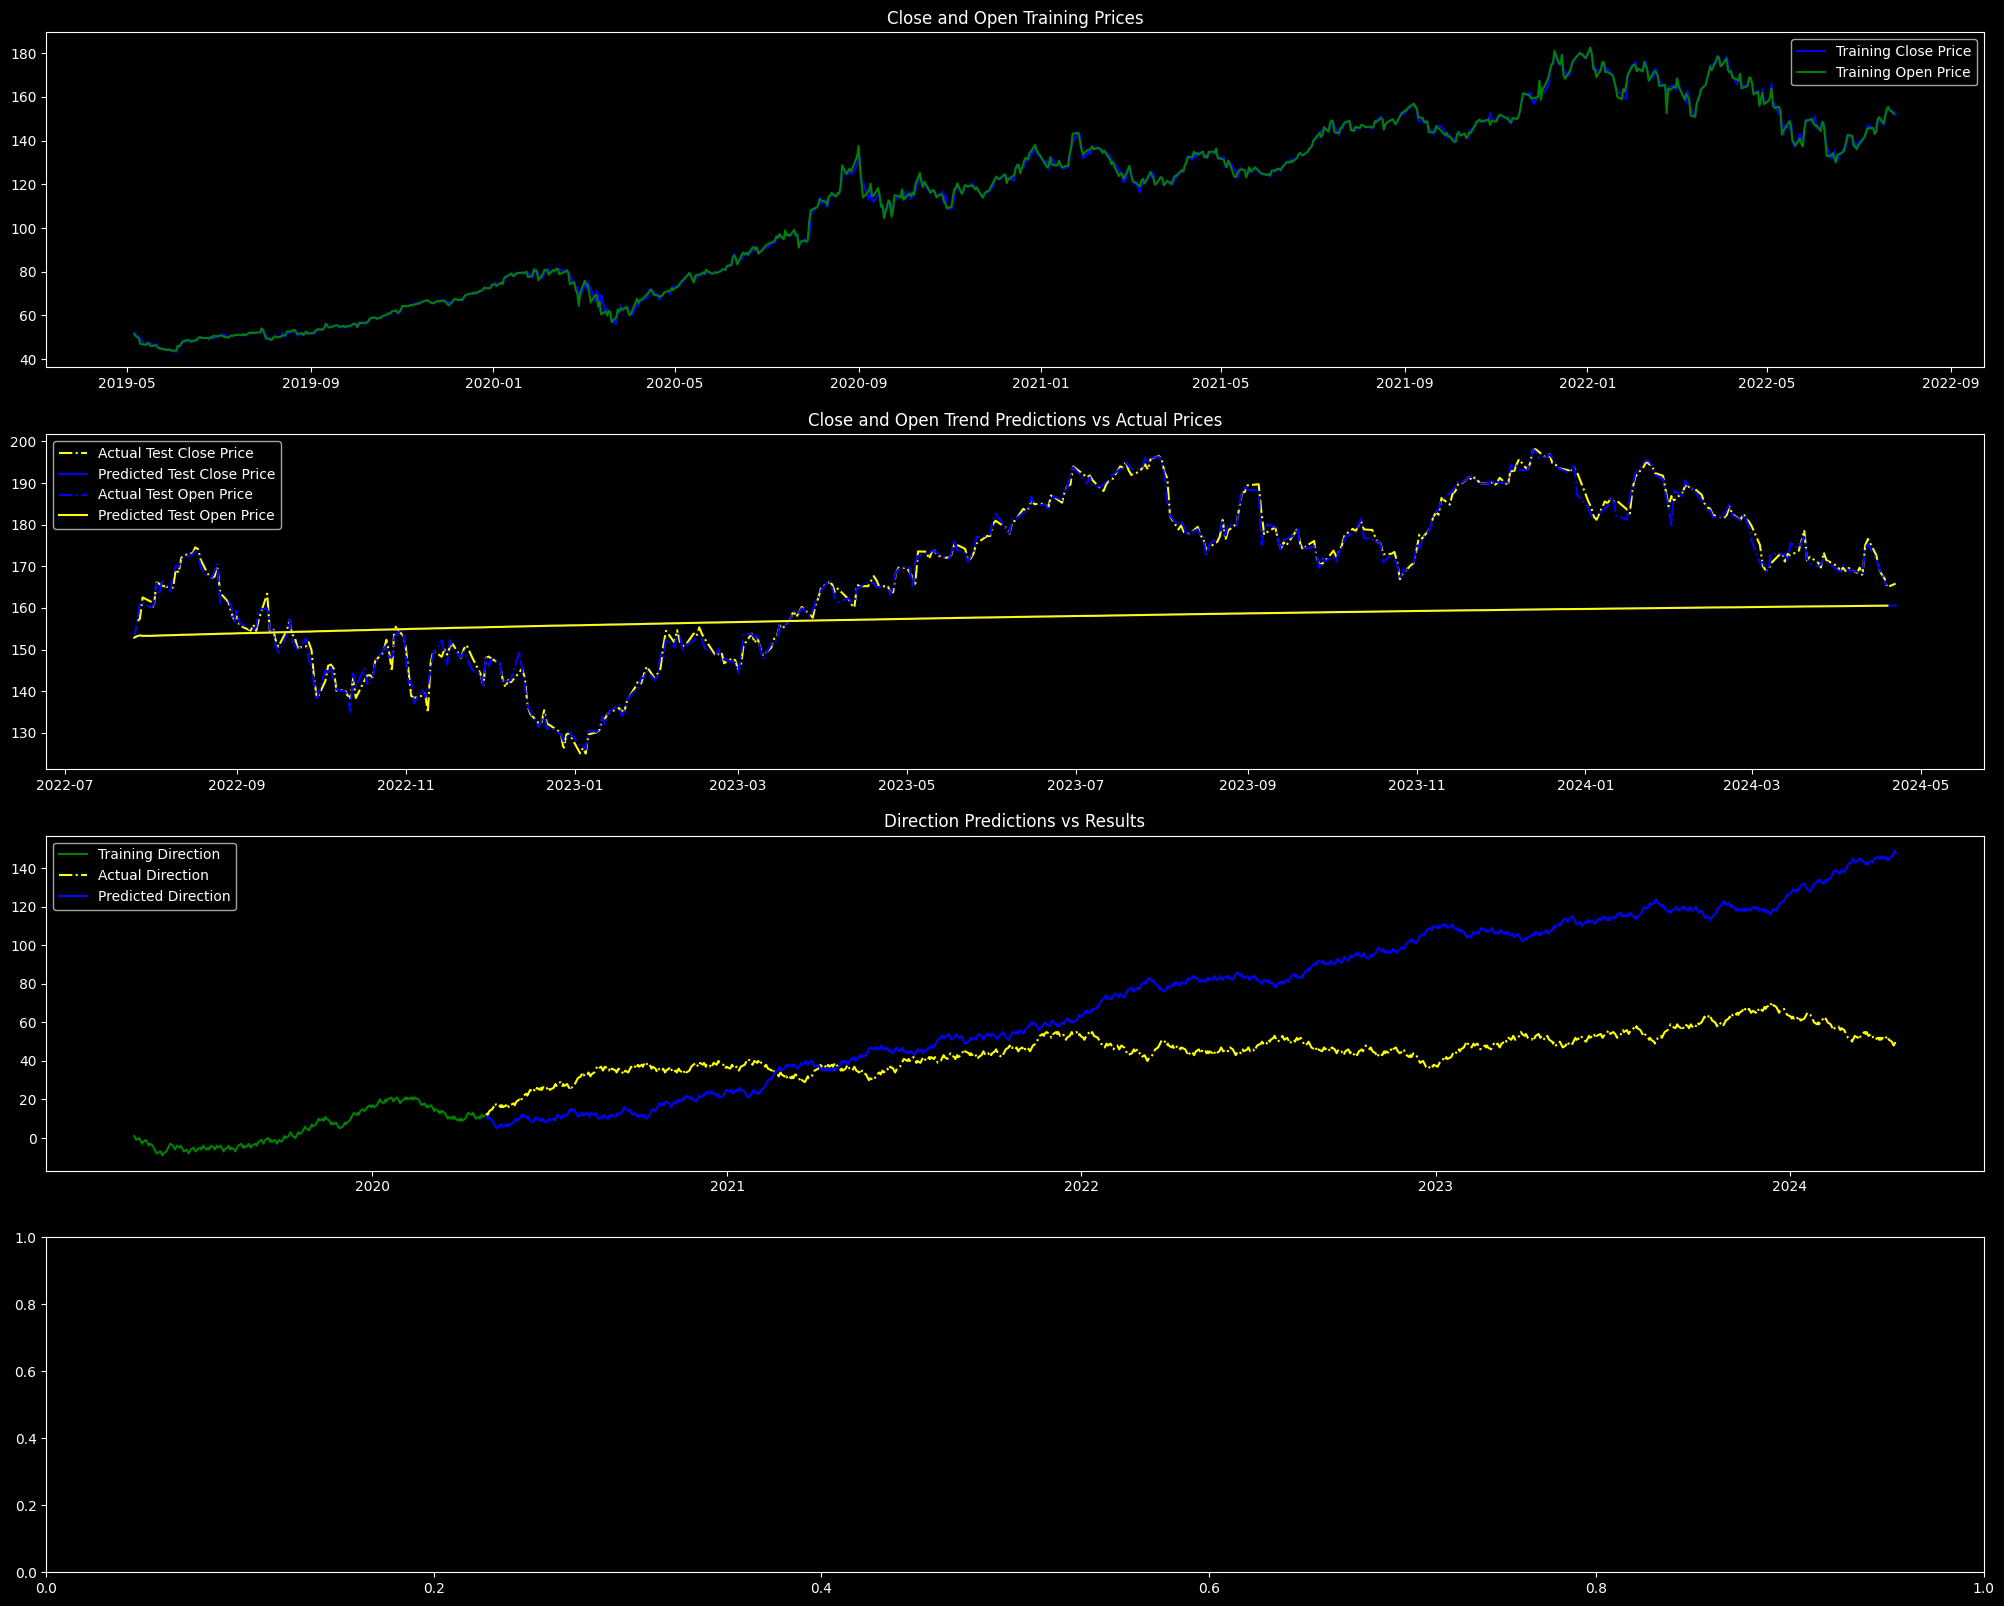

In [922]:
prediction.graph()

End Prediction Score:  0.9856911522593209
Open Prediction Score:  0.9932345455412438
Direction Prediction Score:  0.5059880239520959


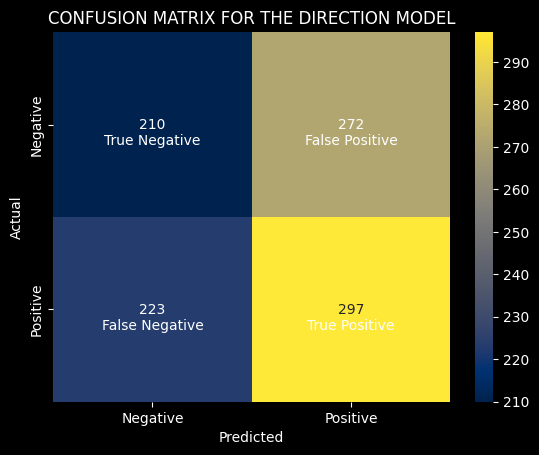

Classification Report: 
              precision    recall  f1-score   support

        -1.0       0.48      0.44      0.46       482
         1.0       0.52      0.57      0.55       520

    accuracy                           0.51      1002
   macro avg       0.50      0.50      0.50      1002
weighted avg       0.50      0.51      0.50      1002



(0.9856911522593209, 0.9932345455412438, 0.5059880239520959)

In [923]:
prediction.evaluate()